Here we shall analyse stocks using Conv1d layer with window of 60 days and we shall do 10 days prediction. We shall follow the philosophy of WaveNet. Thanks to https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb
# Imports

In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt

2024-05-25 03:35:55.205883: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 03:35:55.208850: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 03:35:55.251432: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 03:35:56.098309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("scalati.csv.gz")[:1000000][["uuid","user_minmax_steps"]]
df.head()

,uuid,user_minmax_steps
0,1003e58667235e01b49008155604980b3900b00e,0.169272
1,1003e58667235e01b49008155604980b3900b00e,0.239404
2,1003e58667235e01b49008155604980b3900b00e,0.013856
3,1003e58667235e01b49008155604980b3900b00e,0.284364
4,1003e58667235e01b49008155604980b3900b00e,0.123650


In [3]:
df.dropna(inplace=True)

In [4]:
xtrain = []
ytrain = []
xtest=[]
ytest=[]
window=50
test_ratio=0.1
for uuid, group in df.groupby('uuid')["user_minmax_steps"]:
    split=int(len(group)*(1-test_ratio))
    if split<window:
        continue
        
    group = np.array(group.values)


    for i in range (window,split):
        xtrain.append(group[i-window:i])
        ytrain.append(group[i])

    for i in range (split,len(group)):
        xtest.append(group[i-window:i])
        ytest.append(group[i])

xtrain=np.array(xtrain).reshape(-1,window,1)
ytrain=np.array(ytrain).reshape(-1,1)
xtest=np.array(xtest).reshape(-1,window,1)
ytest=np.array(ytest).reshape(-1,1)

In [5]:
inputs = keras.Input(shape=xtrain[0].shape)
conv1d_1=keras.layers.Conv1D(filters=20, kernel_size=2, activation="relu", dilation_rate=1, padding="causal")(inputs)
conv1d_2=keras.layers.Conv1D(filters=20, kernel_size=2, activation="relu", dilation_rate=2, padding="causal")(conv1d_1)
conv1d_3=keras.layers.Conv1D(filters=20, kernel_size=2, activation="relu", dilation_rate=4, padding="causal")(conv1d_2)
conv1d_4=keras.layers.Conv1D(filters=20, kernel_size=2, activation="relu", dilation_rate=8, padding="causal")(conv1d_3)
conv1d_5=keras.layers.Conv1D(filters=10, kernel_size=1, padding="causal")(conv1d_4)
flatten = keras.layers.Flatten()(conv1d_5)
output = keras.layers.Dense(1, activation='sigmoid')(flatten)

model=keras.Model(inputs=inputs, outputs=output)
model.compile(loss=keras.losses.MeanAbsoluteError())
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 50, 20)         │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 50, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 50, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 50, 10)         │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,231 (12.62 KB)

 Trainable params: 3,231 (12.62 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from keras.src.callbacks import EarlyStopping

history = model.fit(xtrain, ytrain, epochs=20, verbose=1, batch_size=32, validation_split=.2, callbacks=EarlyStopping(patience=5))

Epoch 1/20
15444/15444 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.1278 - val_loss: 0.1237
Epoch 2/20
15444/15444 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 0.1237 - val_loss: 0.1240
Epoch 3/20
15444/15444 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.1232 - val_loss: 0.1234
Epoch 4/20
15444/15444 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.1232 - val_loss: 0.1239
Epoch 5/20
15444/15444 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.1230 - val_loss: 0.1232
Epoch 6/20
15444/15444 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.1228 - val_loss: 0.1231
Epoch 7/20
15444/15444 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.1228 - val_loss: 0.1235
Epoch 8/20
15444/15444 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 0.1224 - val_loss: 0.1231
Epoch 9/20
15444/15444 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.1226 - val_loss: 0.1239
Epoch 10/20
15444/15444 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.1224 - val_loss: 0.1234
Epoch 11/20
15444/15444 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 0.1224 - val_loss: 0.12

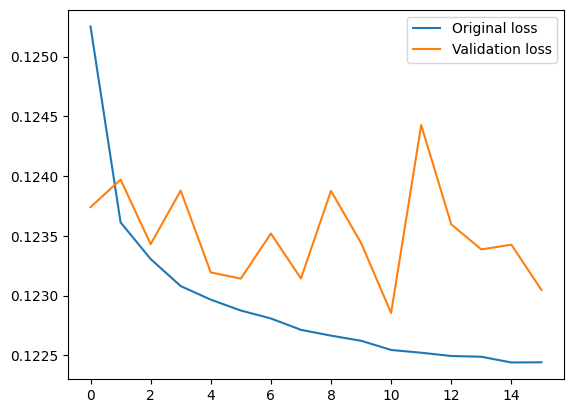

In [7]:
plt.plot(history.history['loss'], label='Original loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [8]:
model.evaluate(xtest, ytest, batch_size=32)

3047/3047 ━━━━━━━━━━━━━━━━━━━━ 3s 877us/step - loss: 0.1228


0.12315285950899124

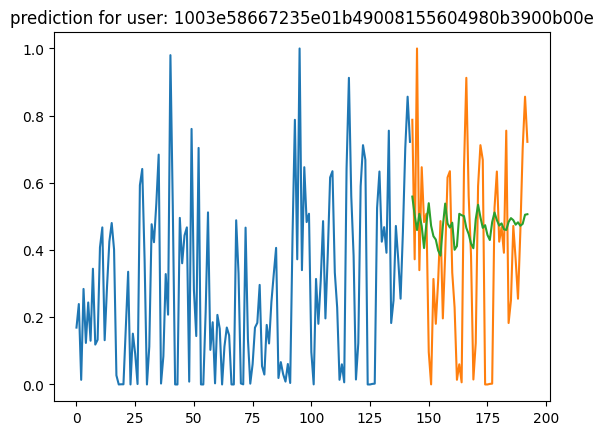

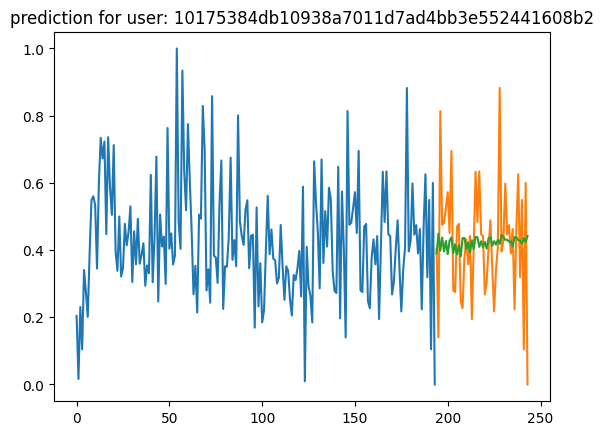

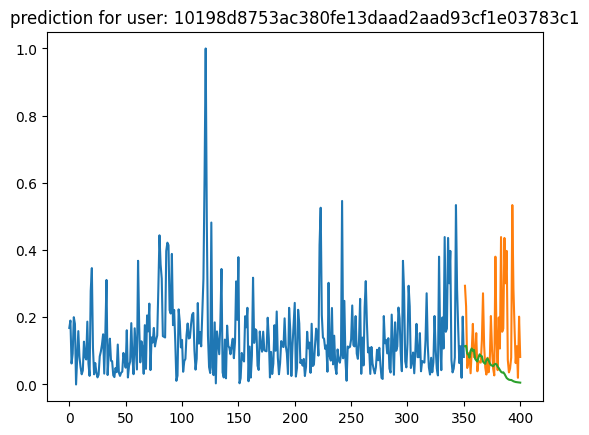

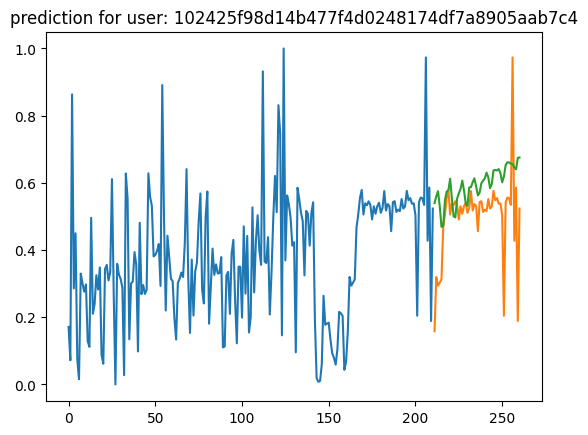

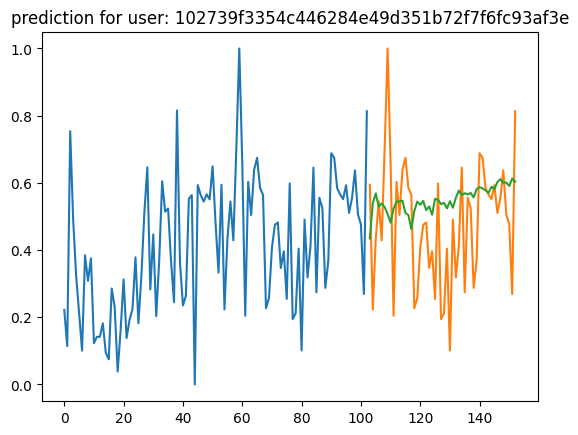

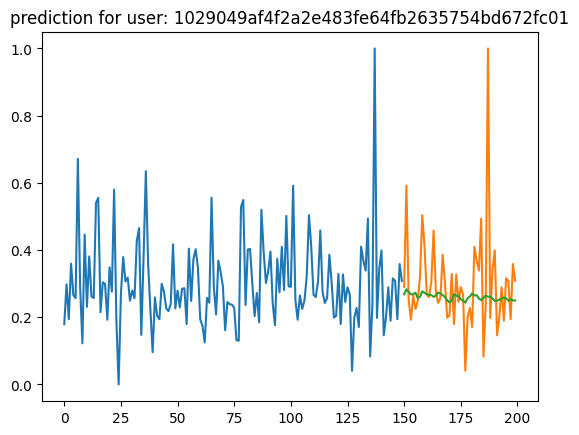

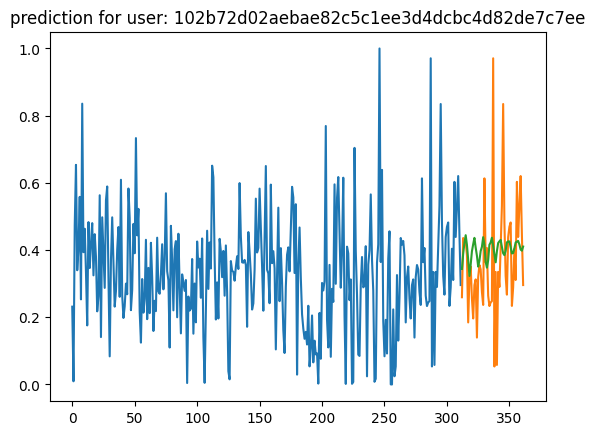

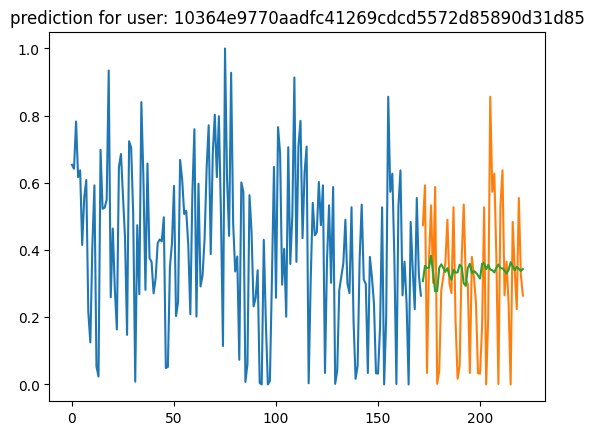

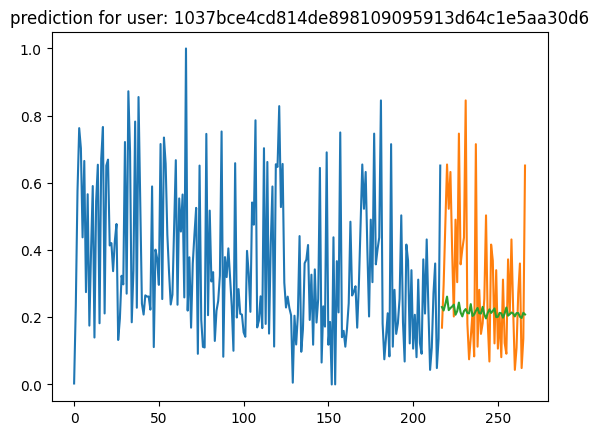

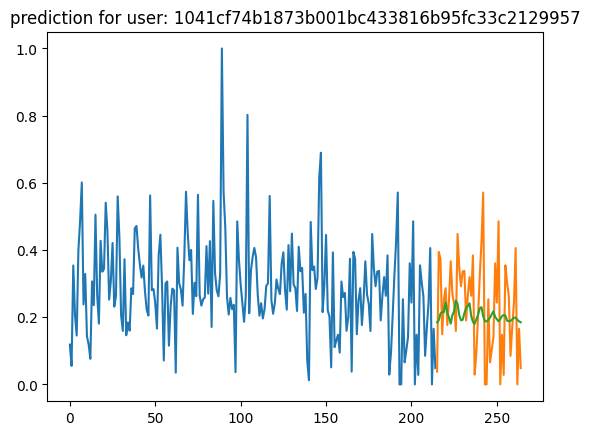

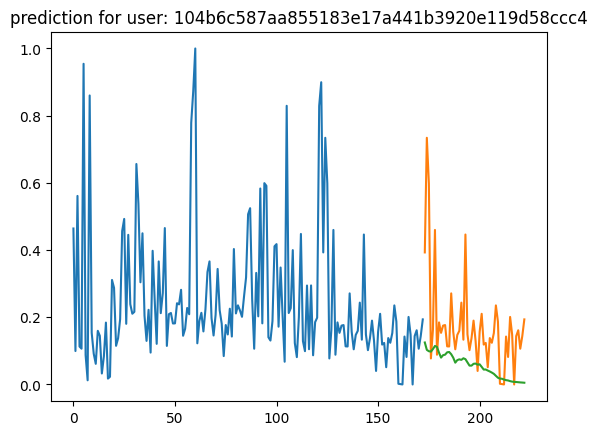

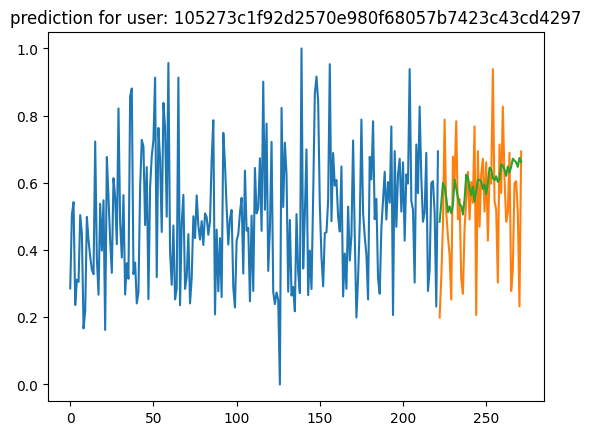

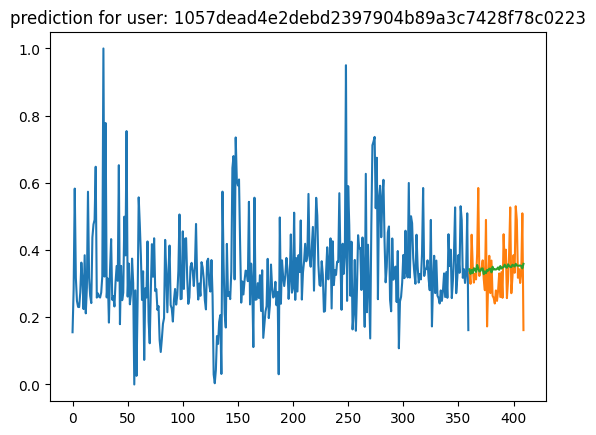

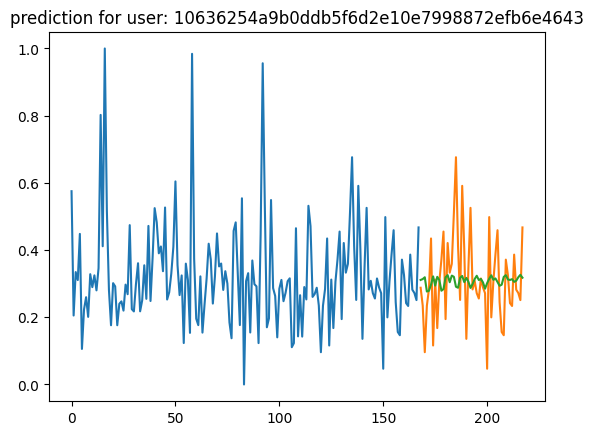

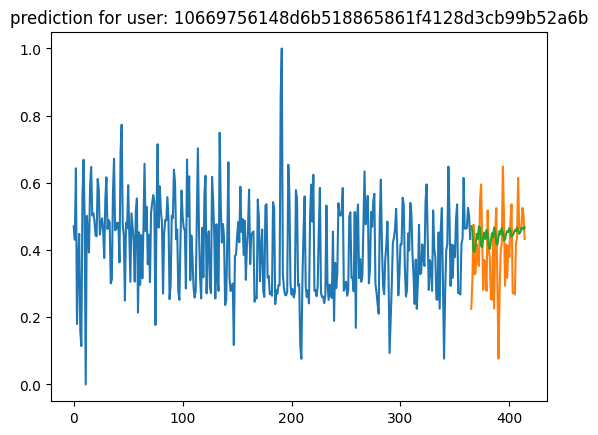

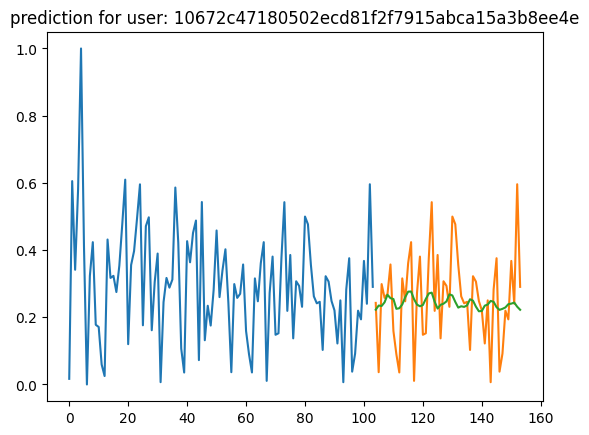

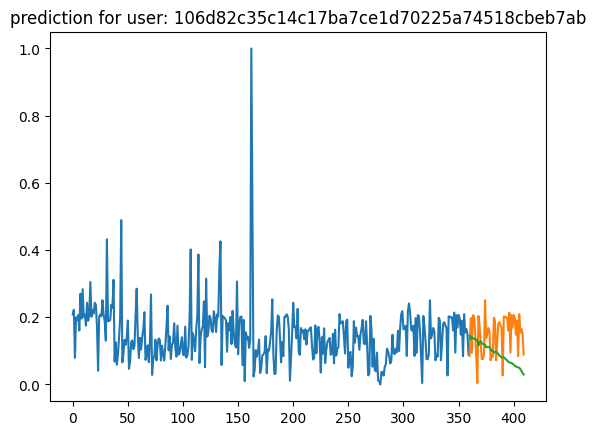

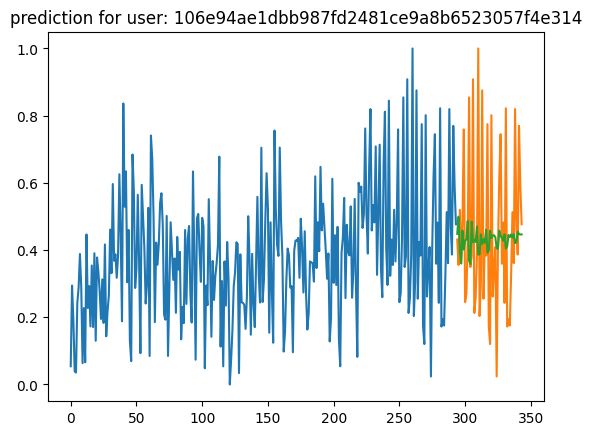

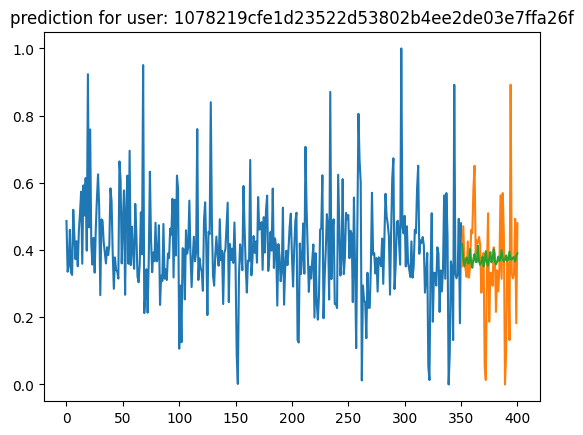

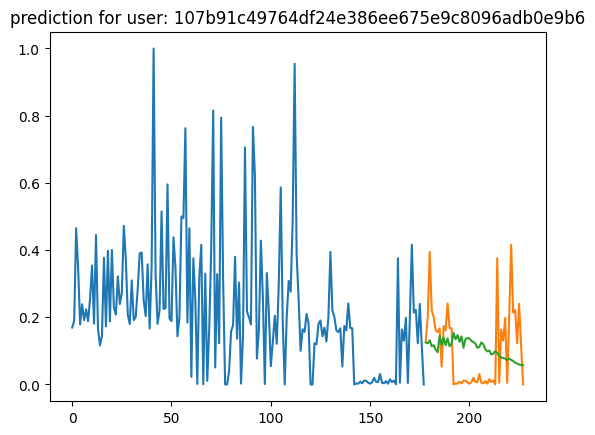

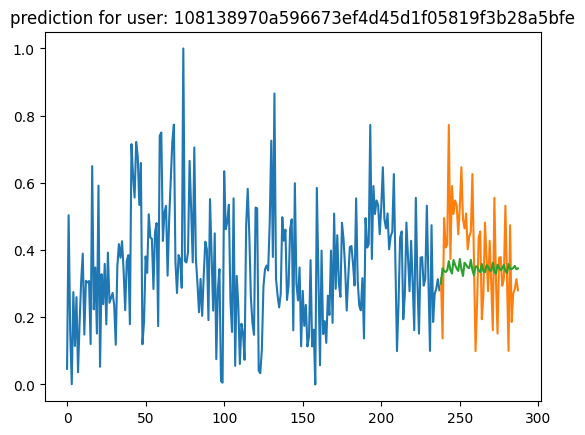

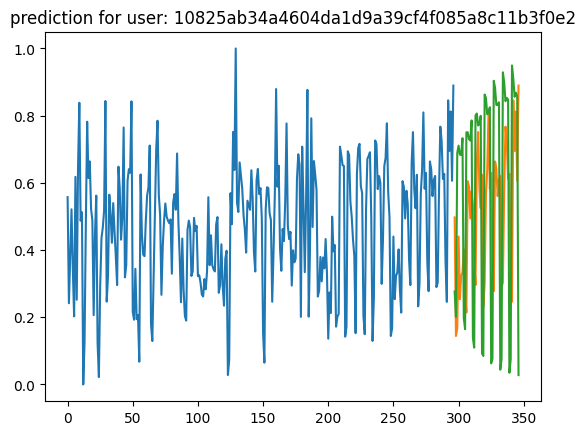

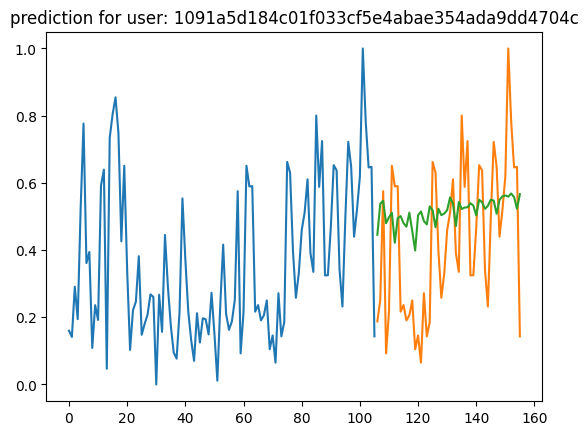

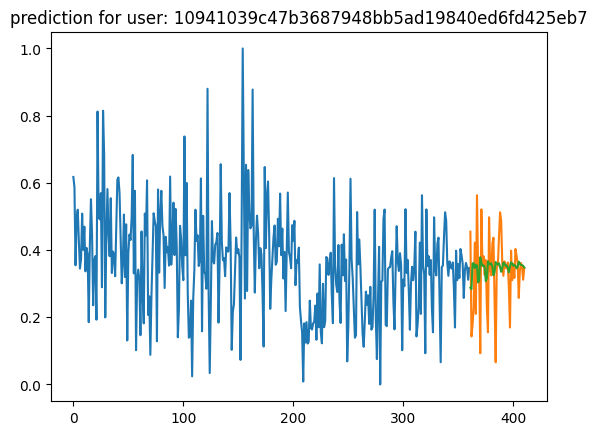

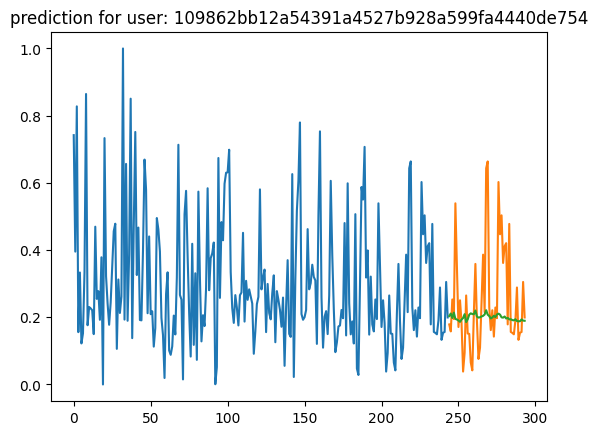

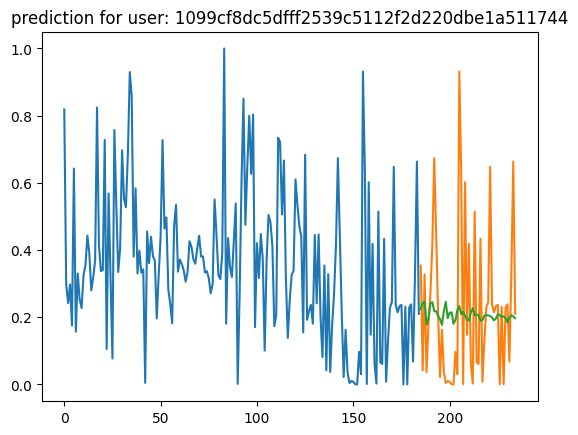

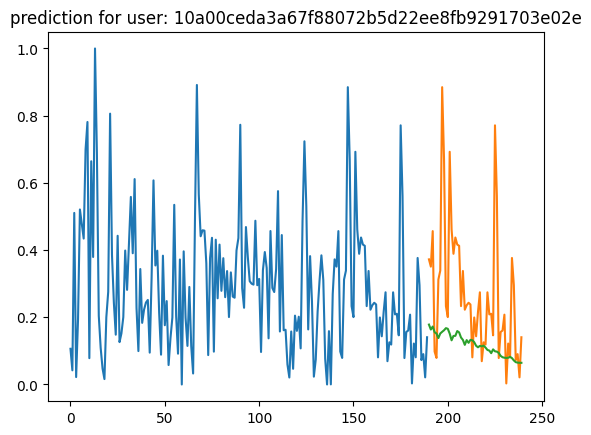

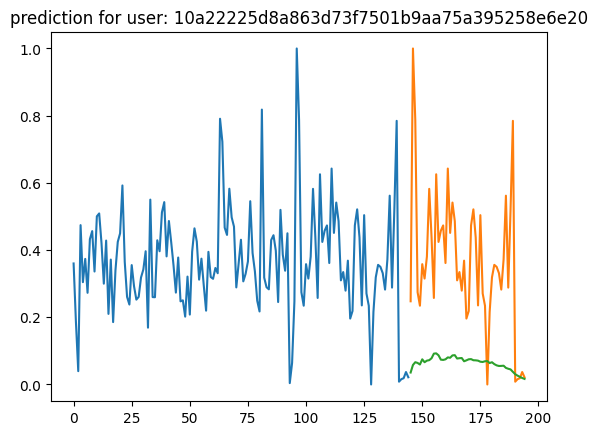

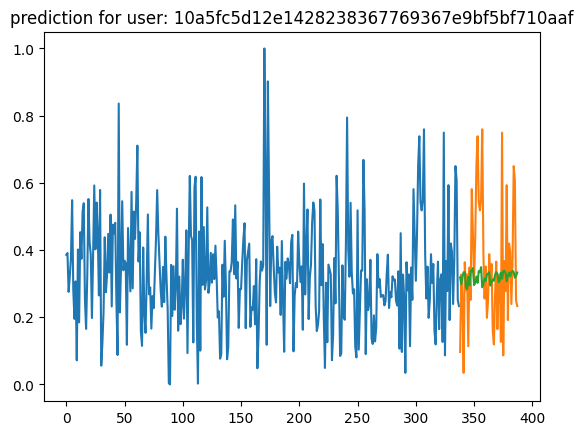

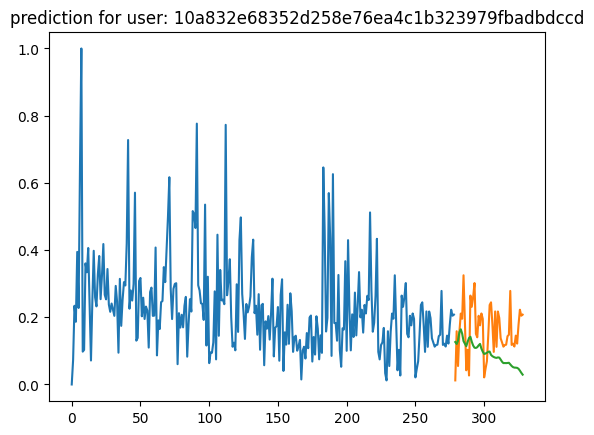

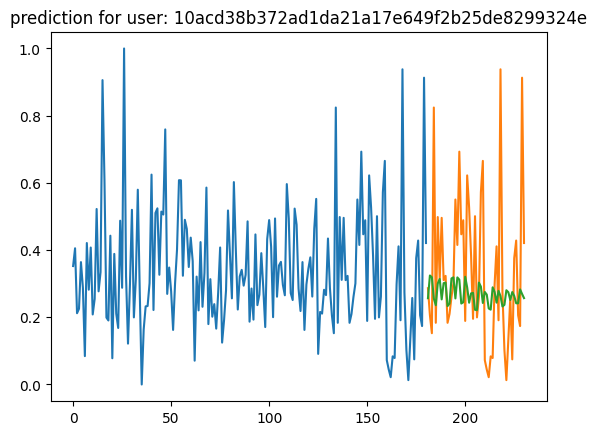

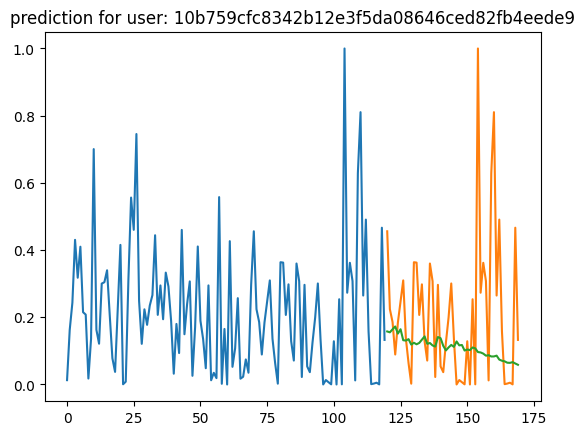

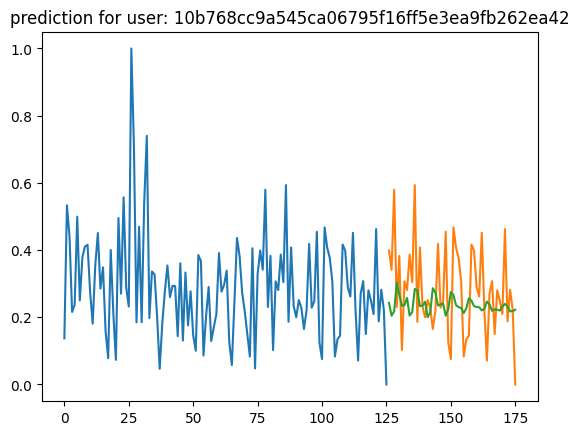

KeyboardInterrupt: 

In [10]:
for uuid,group in df.groupby('uuid')["user_minmax_steps"]:
    if len(group)<2*window:
        continue
    common = group.values
    actual=group[-window:].values
    pred=[]
    dati=common[-window:]
    for i in range(window):
        # new_date=dati[-1,1]+1/len(group)
        new_entry=[
            model.predict(np.array([dati]),verbose=0)[0][0]
            # new_date
        ]
        pred.append(new_entry)
        dati = np.concatenate((dati, new_entry))[-window:]
    pred=np.array(pred)
    plt.title("prediction for user: "+uuid)
    plt.plot([i for i in range(len(common))],common, label='Truth')
    plt.plot([i+len(common) for i in range(len(actual))],actual,label='Actual')
    plt.plot([i+len(common) for i in range(len(pred))],pred,label='Predicted')
    plt.show()
    plt.close()


In [11]:
model.save("modello-passi.keras")